# Homework 2 (Redo)

Name: Syed Zain Raza

## Setup Code

In [28]:
# optional: allow Jupyter to "hot reload" the Python modules I wrote, to avoid restarting the kernel after every change
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

from util import ops

In [6]:
dart_img = ops.load_image(
    "./Dartt3.png",
    return_array=True,
    return_grayscale=True,
)

Dimensions of ./Dartt3.png: 556 x 640


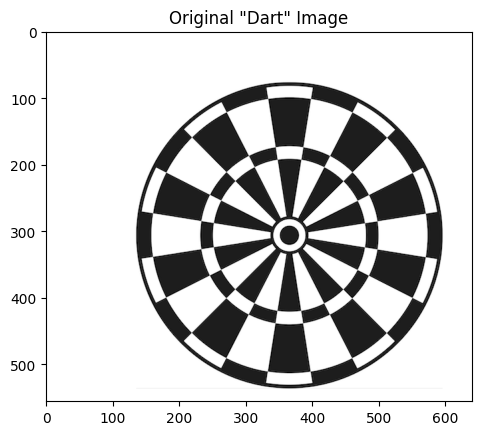

In [15]:
plt.imshow(dart_img, cmap="gray")
plt.title("Original \"Dart\" Image")
plt.show()

## Problem 1: Edge Detection

In [30]:
from util.gaussian_derivative import GaussianDerivativeFilter

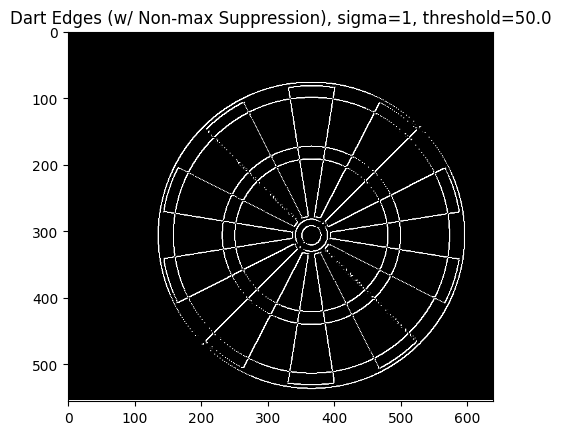

In [12]:
output_image = GaussianDerivativeFilter.detect_edges_and_visualize(
    image=dart_img,
    image_name="Dart",
    sigma=1,  # default
    threshold=50.0,
    use_non_max_suppression=True,
    padding_type="zero",
)

## Center Center Detection

### Problem 2: Hough Transform Voting of Edges Belonging to the Circles 

In [95]:
from util.model_fitting import HoughTransformFitter, HoughTransformCircleCenterDetector

In [85]:
from typing import Tuple, Union
import numpy as np

from util import ops


def hough_circle_transform(
    edges_img: np.ndarray,
    orientation_img: np.ndarray,
    plot_title: str,
    radius_interval: Tuple[int, int] = (5, 10),
    mode: Union[str, str] = "use_circles",  # or, can be "use_lines"
    logging_enabled: bool = False,
) -> np.ndarray:
    ### HELPER(S)
    def _find_potential_circle_centers(
        x: int, y: int, radius: float, gradient_angle: float, mode: str
    ) -> np.array:
        # Compute the points in the direction/opposite direction of the gradient (aka theta)
        direction_vector = np.array([np.cos(gradient_angle), np.sin(gradient_angle)])
        point1 = np.array([x, y]) + (
            radius * direction_vector
        )  # point in the direction of the grad
        point2 = np.array([x, y]) - (radius * direction_vector)  # opposite direction
        center_coords = np.concatenate(
            [point1.reshape(1, 2), point2.reshape(1, 2)],
            axis=0,
        )

        if mode == "use_lines":
            # find the line containing pixel, in the direction orthogonal to the gradient
            perpendicular_rotation = np.array(
                [
                    [np.cos(angle + np.pi / 2), -np.sin(angle + np.pi / 2)],
                    [np.sin(angle + np.pi / 2), np.cos(angle + np.pi / 2)],
                ]
            )
            orthogonal_coords = np.dot(perpendicular_rotation, center_coords)
            center_coords = orthogonal_coords

        return center_coords.astype(int)

    ### DRIVER
    # Define accumulator array
    radii_range = radius_interval[1] - radius_interval[0]
    accumulator = np.zeros(
        (edges_img.shape[0], edges_img.shape[1], radii_range)
    ).astype(int)

    # Generate a range of radii to consider
    radii = np.arange(start=radius_interval[0], stop=radius_interval[1])

    # Loop over edge pixels
    for y in np.arange(edges_img.shape[0]):
        for x in np.arange(edges_img.shape[1]):
            for r in radii:
                radius_adjusted = r - radius_interval[0]
                edge_pixel = edges_img[y][x]
                # check if it's an edge pixel
                if edge_pixel > 0:
                    angle = orientation_img[y][x]
                    # Vote for possible circle centers
                    potential_center_points = _find_potential_circle_centers(
                        x, y, r, angle, mode=mode
                    )
                    # now make a vote
                    for column, row in potential_center_points:
                        if (-1 < row < accumulator.shape[0]) and (
                            -1 < column < accumulator.shape[1]
                        ):
                            accumulator[row, column, radius_adjusted] += 1
                        elif logging_enabled:
                            print(
                                f"Warning: coords ({row}, {column}, {radius_adjusted}) out of bounds for accumulator of shape: ({accumulator.shape})"
                            )

    # find the best radius to try and find the center at
    highest_votes = np.max(accumulator, axis=(0, 1)).squeeze()
    assert (
        highest_votes.shape[0] == accumulator.shape[2]
    ), f"Double check our max() op, it results in a shape mismatch: ({highest_votes.shape}) != ({accumulator.shape[2]})"
    best_radius_index = np.argmax(highest_votes)
    # find the proposed center at every radius length
    accumulator_single_radius = accumulator[:, :, best_radius_index]
    # apply non-maximum suppression
    accumulator_max = HoughTransformFitter.non_max_suppression(
        accumulator_single_radius
    )
    accumulator_max = accumulator_single_radius
    assert accumulator_max.shape == (
        accumulator_single_radius.shape
    ), f"Error: double check axis used for Hough transform. Shape mismatch: ({accumulator_max.shape}) != ({accumulator_single_radius.shape})"

    # Find the most likely center
    indices_1d = np.argmax(accumulator_max[:, :])
    indices_2d = np.array(
        ops.convert_1d_indices_to_2d(accumulator_single_radius, indices_1d)
    ).reshape(1, 2)
    assert indices_2d.shape == (
        1,
        2,
    ), f"Error: double check shape of indices. Shape mismatch: ({indices_2d.shape }) != ({(1, 2)})"

    # plot the point
    plt.imshow(dart_img, cmap="gray")
    plt.scatter(x=indices_2d[0, 0], y=indices_2d[0, 1], color="r", s=20)
    plt.title(plot_title)
    plt.show()

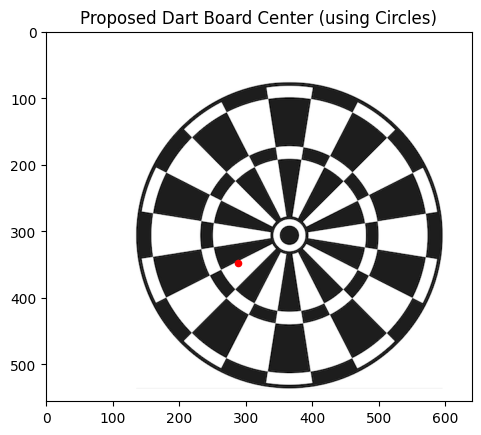

In [92]:
filter = GaussianDerivativeFilter()
(
    partial_derivative_y,
    partial_derivative_x,
) = filter._compute_derivatives(dart_img)
orientation_image = np.arctan2(partial_derivative_y, partial_derivative_x)
HoughTransformCircleCenterDetector.fit_and_report(
    dart_img,
    output_image,
    orientation_image,
    radius_interval=(7, 12),
    voting_threshold=1,
    plot_title="Proposed Dart Board Center (using Circles)",
    mode="use_circles",  # or, can be "use_lines"
)

### Problem 3: Hough Transform Voting of Edges Belonging to the Straight Lines 

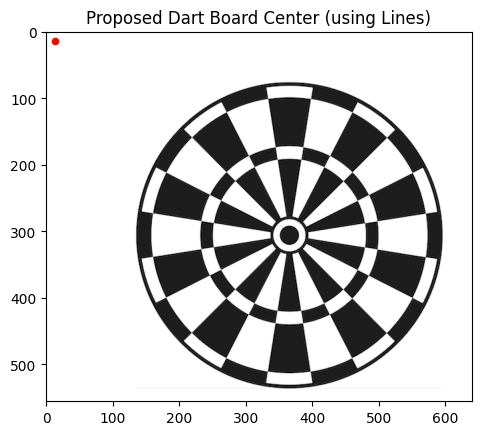

In [93]:
HoughTransformCircleCenterDetector.fit_and_report(
    dart_img,
    output_image,
    orientation_image,
    voting_threshold=1,
    radius_interval=(9, 17),
    plot_title="Proposed Dart Board Center (using Lines)",
    mode="use_lines",  # or, can be "use_lines"
)